# Sequential Batch Learning in Stochastic MAB and Contextual MAB on Mushroom and Synthetic data

## Executive summary

| | |
| --- | --- |
| Problem | Learning user preferences online might have an impact of delay and training recommender system sequentially for every example is computationally heavy. |
| Hypothesis | A learning agent observes responses batched in groups over a certain time period. The impact of batch learning can be measured in terms of online behavior. |
| Prblm Stmt. | Given a finite set of arms ⁍, an environment ⁍ (⁍ is the distribution of rewards for action ⁍), and a time horizon ⁍, at each time step ⁍, the agent chooses an action ⁍ and receives a reward ⁍. The goal of the agent is to maximize the total reward ⁍. |
| Solution | Sequential batch learning is a more generalized way of learning which covers both offline and online settings as special cases bringing together their advantages. Unlike offline learning, sequential batch learning retains the sequential nature of the problem. Unlike online learning, it is often appealing to implement batch learning in large scale bandit problems. In this setting, responses are grouped in batches and observed by the agent only at the end of each batch. |
| Dataset | Mushroom, Synthetic |
| Preprocessing | Train/test split, label encoding |
| Metrics | Conversion rate, regret |
| Credits | [Danil Provodin](https://github.com/danilprov) |

### Environments

| Name | Type | Rewards |
| --- | --- | --- |
| env1 | 2-arm environment | [0.7, 0.5] |
| env2 | 2-arm environment | [0.7, 0.4] |
| env3 | 2-arm environment | [0.7, 0.1] |
| env4 | 4-arm environment | [0.35, 0.18, 0.47, 0.61] |
| env5 | 4-arm environment | [0.40, 0.75, 0.57, 0.49] |
| env6 | 4-arm environment | [0.70, 0.50, 0.30, 0.10] |

### Simulation

| Application | Policy |
| --- | --- |
| Multi-armed bandit (MAB) | Thompson Sampling (TS) |
| Multi-armed bandit (MAB) | Upper Confidence Bound (UCB) |
| Contextual MAB (CMAB) | Linear Thompson Sampling (LinTS) |
| Contextual MAB (CMAB) | Linear UCB (LinUCB) |

## Process flow

![](https://github.com/RecoHut-Stanzas/S873634/raw/main/images/process_flow.svg)

## Setup

### Imports

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from scipy.optimize import minimize
from lightgbm import LGBMClassifier
from scipy.stats import beta
import pickle
import os
import shutil

import tqdm
from tqdm.notebook import tqdm
from multiprocessing.dummy import Pool
from IPython.display import clear_output
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from __future__ import print_function
from abc import ABCMeta, abstractmethod

## Data

### Download

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like ``leaflets three, let it be'' for Poisonous Oak and Ivy. More details [here](https://archive.ics.uci.edu/ml/datasets/mushroom).

In [ ]:
!mkdir -p data
!cd data && wget -q --show-progress https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
!cd data && wget -q --show-progress https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names

agaricus-lepiota.da 100%[===================>] 364.95K  1.31MB/s    in 0.3s    
agaricus-lepiota.na 100%[===================>]   6.66K  --.-KB/s    in 0s      


### Preprocessing

In [ ]:
mushroom_data = pd.read_csv("data/agaricus-lepiota.data", header=None)

column_names = ["classes", "cap-shape", "cap-surface", "cap-color", "bruises?", "odor", "gill-attachment",
                "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring",
                "stalk-surface-below-ring", "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", 
                "veil-color", "ring-number", "ring-type", "spore-print-color", "population", "habitat"]
                
mushroom_data.columns = column_names
mushroom_data.head()

,classes,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
mushroom_data.dtypes

classes                     object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises?                    object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [ ]:
# label encoding
for column in column_names:
    mushroom_data[column] = mushroom_data[column].astype('category')
    mushroom_data[column] = mushroom_data[column].cat.codes

# split
idx_trn, idx_tst = train_test_split(mushroom_data.index, test_size=0.2, random_state=42, 
                                    stratify=mushroom_data[['classes']])

gini by factors

In [ ]:
def gini(var):
    df = mushroom_data.copy()
    x_trn = df.loc[idx_trn, var]
    y_trn = df.loc[idx_trn, 'classes']
    x_tst = df.loc[idx_tst, var]
    y_tst = df.loc[idx_tst, 'classes']
    
    if x_trn.dtype in ['O','object']:
        cats = pd.DataFrame({'x': x_trn, 'y': y_trn}).fillna('#NAN#').groupby('x').agg('mean').sort_values('y').index.values
        X_trn = pd.Categorical(x_trn.fillna('#NAN#'), categories=cats, ordered=True).codes.reshape(-1, 1)
        X_tst = pd.Categorical(x_tst.fillna('#NAN#'), categories=cats, ordered=True).codes.reshape(-1, 1)
    else:
        repl = min(x_trn.min(), x_tst.min())-1 if np.isfinite(min(x_trn.min(), x_tst.min())-1) else -999999
        #repl = x_trn.min()-1 if np.isfinite(x_trn.min())-1 else -999999
        X_trn = x_trn.fillna(repl).replace(np.inf, repl).replace(-np.inf, repl).values.reshape(-1, 1)
        X_tst = x_tst.fillna(repl).replace(np.inf, repl).replace(-np.inf, repl).values.reshape(-1, 1)
    
    obvious_gini_trn = 2*roc_auc_score(y_trn, X_trn)-1
    obvious_gini_tst = 2*roc_auc_score(y_tst, X_tst)-1

    if obvious_gini_trn < 0:
        obvious_gini_trn = -obvious_gini_trn
        obvious_gini_tst = -obvious_gini_tst

    parameters = {'min_samples_leaf':[0.01, 0.025, 0.05, 0.1]}
    dt = DecisionTreeClassifier(random_state=1)
    clf = GridSearchCV(dt, parameters, cv=4, scoring='roc_auc', n_jobs=10)
    clf.fit(X_trn, y_trn)

    true_gini_trn = 2*clf.best_score_-1
    true_gini_tst = 2*roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1])-1

    if true_gini_trn < 0:
        true_gini_trn = -true_gini_trn
        true_gini_tst = -true_gini_tst

    if obvious_gini_trn > true_gini_trn:
        return [var, obvious_gini_trn, obvious_gini_tst]
    else:
        return [var, true_gini_trn, true_gini_tst]

In [ ]:
with Pool(20) as p:
    vars_gini = list(tqdm(p.imap(gini, column_names), total=len(column_names)))

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
vars_gini = pd.DataFrame(vars_gini)
vars_gini.set_index(0, inplace=True)
vars_gini.columns = ['gini_train', 'gini_test']

vars_gini.T

,classes,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
gini_train,1.0,0.185225,0.180956,0.207793,0.495815,0.967487,0.040117,0.256251,0.490563,0.758349,0.10296,0.429898,0.543743,0.534091,0.544061,0.534553,0.0,0.045791,0.114617,0.627000,0.761604,0.519078,0.444780
gini_test,1.0,0.212779,0.201118,0.237278,0.490001,0.969555,0.044683,0.257858,0.535203,0.760057,0.09395,0.426011,0.530422,0.532951,0.528023,0.516607,0.0,0.054705,0.117193,0.622052,0.746050,0.510436,0.476353


Correlation analysis

In [ ]:
vars_corrs = mushroom_data.loc[:, column_names].corr().abs().stack().reset_index().drop_duplicates()
vars_corrs = vars_corrs[vars_corrs.level_0!=vars_corrs.level_1]
vars_corrs.columns = ['var_1', 'var_2', 'correlation']
vars_corrs = vars_corrs.set_index(['var_1', 'var_2'], drop=True).sort_values(by='correlation', ascending=False)

vars_drop = []

for v in vars_corrs[vars_corrs.correlation > 0.7].index.values:
    if v[0] not in vars_drop and v[1] not in vars_drop:
        vars_drop.append(v[1] if vars_gini.loc[v[0], 'gini_train'] > vars_gini.loc[v[1], 'gini_train'] else v[0])
        
del v

Feature selection

In [ ]:
# all variables
vars0 = column_names[1:]

# drop values with gini less than 3%
vars1 = [v for v in vars0 if vars_gini.loc[v, 'gini_train'] >= 0.03]

# drop correlated variables
vars2 = [v for v in vars1 if v not in vars_drop]

i = 0

for var_lst in [vars0, vars1, vars2]:
    i += 1
    lgb = LGBMClassifier(max_depth=1, n_estimators=250, random_state=42, n_jobs=30)
    
    cv = cross_validate(lgb, mushroom_data.loc[:, var_lst], mushroom_data.loc[:, 'classes'], 
                        cv=5, scoring='roc_auc', n_jobs=20, return_train_score=True)
    
    lgb.fit(mushroom_data[var_lst], mushroom_data['classes'])
    
    print({'Variables': len(var_lst), 
           'Train CV': round(cv['train_score'].mean()*2-1, 4), 
           'Test CV': round(cv['test_score'].mean()*2-1, 4)})
    
var_lst_imp = pd.Series(dict(zip(var_lst, lgb.feature_importances_)))
var_lst = [i for i in var_lst_imp.index if var_lst_imp.loc[i]>0]
print({'exclude': [i for i in var_lst_imp.index if var_lst_imp.loc[i]<=0]})
print(len(var_lst))

forw_cols = []
current_ginis = pd.Series({'Train CV':0, 'Test CV':0})

def forw(x):
    lgb = LGBMClassifier(max_depth=1, n_estimators=250, random_state=42, n_jobs=1)
    cv = cross_validate(lgb, mushroom_data.loc[:, forw_cols+[x]], mushroom_data.loc[:, 'classes'],
                        cv=5, scoring='roc_auc', n_jobs=1, return_train_score=True)
    lgb.fit(mushroom_data.loc[:, forw_cols+[x]], mushroom_data.loc[:, 'classes'])
    return x, pd.Series({
        'Train CV': cv['train_score'].mean()*2-1,
        'Test CV': cv['test_score'].mean()*2-1
    })

forwards_log = []
while len(forw_cols)<30:
    with Pool(20) as p:
        res = list(tqdm(p.imap(forw, [i for i in var_lst if i not in forw_cols]), total=len(var_lst)-len(forw_cols), leave=False))
    res = pd.DataFrame({i[0]:i[1] for i in res}).T
    delta = res - current_ginis
    if delta['Test CV'].max()<0:
        break
    best_var = delta['Test CV'].idxmax()
    forw_cols = forw_cols + [best_var]
    current_ginis = res.loc[best_var]
    forwards_log.append(current_ginis)
    clear_output()
    print(pd.DataFrame(forwards_log))

clear_output()
forwards_log = pd.DataFrame(forwards_log)
forwards_log['Uplift Train CV'] = forwards_log['Train CV']-forwards_log['Train CV'].shift(1).fillna(0)
forwards_log['Uplift Test CV'] = forwards_log['Test CV']-forwards_log['Test CV'].shift(1).fillna(0)
print(forwards_log)

              Train CV   Test CV  Uplift Train CV  Uplift Test CV
odor          0.970307  0.843798         0.970307        0.843798
gill-size     0.979971  0.958396         0.009664        0.114598
gill-spacing  0.984611  0.964531         0.004640        0.006135
stalk-shape   0.993921  0.982878         0.009310        0.018347
habitat       0.995208  0.984953         0.001287        0.002075


In [ ]:
ids_vars = forwards_log[forwards_log['Uplift Test CV']>0.001].index.values.tolist()
vars_gini.loc[ids_vars,:]

,gini_train,gini_test
0,,
odor,0.967487,0.969555
gill-size,0.490563,0.535203
gill-spacing,0.256251,0.257858
stalk-shape,0.102960,0.093950
habitat,0.444780,0.476353


In [ ]:
mushroom_data_features = mushroom_data[ids_vars + ["classes"]]
mushroom_data = mushroom_data_features.loc[mushroom_data_features.index.repeat(4)].reset_index(drop=True)

mushroom_data["a"] = np.random.choice([0, 1], mushroom_data.shape[0])
mushroom_data["probs"] = 1
mushroom_data["y"] = 0

eat_edible = (1-mushroom_data["classes"]) * mushroom_data["a"] * 1
eat_poisonous = mushroom_data["classes"] * mushroom_data["a"] * np.random.choice([1, -1], mushroom_data.shape[0])
mushroom_data["y"] = eat_edible + eat_poisonous
new_names = ['X_' + str(i+1) for i in range(len(ids_vars))]    
mushroom_data = mushroom_data.rename(columns=dict(zip(ids_vars, new_names)))

mushroom_data_final = mushroom_data[new_names + ['a', 'y', 'probs']]
mushroom_data_final.head()

,X_1,X_2,X_3,X_4,X_5,a,y,probs
0,6,1,0,0,5,1,1,1
1,6,1,0,0,5,0,0,1
2,6,1,0,0,5,0,0,1
3,6,1,0,0,5,1,-1,1
4,0,0,0,0,1,1,1,1


In [ ]:
with open('data/mushroom_data_final.pickle', 'wb') as handle:
    pickle.dump(mushroom_data_final, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Utilities

### Softmax

In [ ]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions).
                       The action-values computed by an action-value network.
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """

    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = action_values / tau
    # Compute the maximum preference across the actions
    max_preference = np.max(preferences, axis=1)

    # your code here

    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    # print(reshaped_max_preference)

    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    # print(exp_preferences)
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = np.sum(exp_preferences, axis=1)
    # print(sum_of_exp_preferences)

    # your code here

    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    # print(reshaped_sum_of_exp_preferences)

    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = exp_preferences / reshaped_sum_of_exp_preferences
    # print(action_probs)

    # your code here

    # squeeze() removes any singleton dimensions. It is used here because this function is used in the
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

In [ ]:
# if __name__ == '__main__':
#     rand_generator = np.random.RandomState(0)
#     action_values = rand_generator.normal(0, 1, (2, 4))
#     tau = 0.5

#     action_probs = softmax(action_values, tau)
#     print("action_probs", action_probs)

#     assert (np.allclose(action_probs, np.array([
#         [0.25849645, 0.01689625, 0.05374514, 0.67086216],
#         [0.84699852, 0.00286345, 0.13520063, 0.01493741]
#     ])))

#     action_values = np.array([[0.0327, 0.0127, 0.0688]])
#     tau = 1.
#     action_probs = softmax(action_values, tau)
#     print("action_probs", action_probs)

#     assert np.allclose(action_probs, np.array([0.3315, 0.3249, 0.3436]), atol=1e-04)

#     print("Passed the asserts! (Note: These are however limited in scope, additional testing is encouraged.)")

action_probs [[0.25849645 0.01689625 0.05374514 0.67086216]
 [0.84699852 0.00286345 0.13520063 0.01493741]]
action_probs [0.33145968 0.32489634 0.34364398]
Passed the asserts! (Note: These are however limited in scope, additional testing is encouraged.)


### Replay buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator.
        """
        self.buffer = []
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward):
        """
        Args:
            state (Numpy array): The state.
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward])

    def sample(self, last_action):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        state, action, reward = map(list, zip(*self.buffer))
        idxs = [elem == last_action for elem in action]
        X = [b for a, b in zip(idxs, state) if a]
        y = [b for a, b in zip(idxs, reward) if a]

        return X, y

    def size(self):
        return len(self.buffer)

In [ ]:
# if __name__ == "__main__":

#     buffer = ReplayBuffer(size=100000, seed=1)
#     buffer.append([1, 2, 3], 0, 1)
#     buffer.append([4, 21, 3], 1, 1)
#     buffer.append([0, 1, 1], 0, 0)

#     print(buffer.sample(0))

([[1, 2, 3], [0, 1, 1]], [1, 0])


### Data Generator

In [ ]:
def generate_samples(num_samples, num_features, num_arms, return_dataframe=False):
    np.random.seed(1)
    # generate pseudo features X and "true" arms' weights
    X = np.random.randint(0, 4, size=(num_samples, num_features))
    actions_weights = np.random.normal(loc=-1., scale=1, size=(num_arms, num_features))

    # apply data generating policy
    policy_weights = np.random.normal(size=(num_arms, num_features))
    action_scores = np.dot(X, policy_weights.T)
    action_probs = softmax(action_scores, tau=10)
    A = np.zeros((num_samples, 1))
    for i in range(num_samples):
        A[i, 0] = np.random.choice(range(num_arms), 1, p=action_probs[i, :])

    # store probabilities of choosing a particular action
    _rows = np.zeros_like(A, dtype=np.intp)
    _columns = A.astype(int)
    probs = action_probs[_rows, _columns]

    # calculate "true" outcomes Y
    ## broadcasting chosen actions to action weights
    matrix_multiplicator = actions_weights[_columns].squeeze()  # (num_samples x num_features) matrix
    rewards = np.sum(X * matrix_multiplicator, axis=1).reshape(-1, 1)
    Y = (np.sign(rewards) + 1) / 2

    if return_dataframe:
        column_names = ['X_' + str(i+1) for i in range(num_features)]
        X = pd.DataFrame(X, columns=column_names)
        A = pd.DataFrame(A, columns=['a'])
        Y = pd.DataFrame(Y, columns=['y'])
        probs = pd.DataFrame(probs, columns=['probs'])

        return pd.concat([X, A, Y, probs], axis=1)
    else:
        return X, A, Y, probs

In [ ]:
# dataset = generate_samples(100000, 4, 3, True)
# dataset.head()

,X_1,X_2,X_3,X_4,a,y,probs
0,1,3,0,0,0.0,0.0,0.266661
1,3,1,3,1,1.0,0.0,0.236514
2,3,0,0,1,1.0,0.0,0.236514
3,0,3,1,0,1.0,0.0,0.236514
4,2,1,2,0,0.0,0.0,0.266661


### Data loader

In [ ]:
def data_randomizer(pickle_file, seed=None):
    if isinstance(pickle_file, str):
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
    else:
        dataset = pickle_file

    actions = sorted(dataset.iloc[:, -3].unique().tolist())
    tst_smpl = pd.DataFrame().reindex_like(dataset).dropna()
    ratio = 0.1

    for action in actions:
        action_subsample = dataset[dataset.iloc[:, -3] == action]
        action_drop, action_use = train_test_split(action_subsample.index, test_size=ratio,
                                                   random_state=seed,
                                                   stratify=action_subsample.iloc[:, -2])
        tst_smpl = pd.concat([tst_smpl,
                              action_subsample.loc[action_use]]).sample(frac=1, random_state=seed)

    tst_smpl = tst_smpl.reset_index(drop=True)

    del action_drop, action_use

    X = tst_smpl.iloc[:, :-3].to_numpy()
    A = tst_smpl.iloc[:, -3].to_numpy()
    Y = tst_smpl.iloc[:, -2].to_numpy()
    probs = tst_smpl.iloc[:, -1].to_numpy()

    return X, A, Y/probs

In [ ]:
class BanditDataset(Dataset):
    def __init__(self, pickle_file, seed=None):
        # load dataset
        X, A, Y = data_randomizer(pickle_file, seed)
        self.features = X
        self.actions = A
        self.rewards = Y

    def __len__(self):
        return len(self.rewards)

    def __getitem__(self, idx):
        feature_vec = self.features[idx]
        action = self.actions[idx]
        reward = self.rewards[idx]

        return feature_vec, action, reward

In [ ]:
# if __name__ == '__main__':
#     dir = 'data/mushroom_data_final.pickle'
#     data = data_randomizer(dir)

#     dataset = BanditDataset(pickle_file=dir, seed=1)
#     print(len(dataset))
#     print(dataset.__len__())
#     print(dataset[420])
#     print(dataset[421])
#     print(dataset[0])
#     print(dataset[1])

#     dl = DataLoader(dataset, batch_size=2, shuffle=True)

#     print(next(iter(dl)))

#     dataset = generate_samples(100000, 4, 3, True)
#     dataset = BanditDataset(pickle_file=dataset, seed=1)
#     print(len(dataset))
#     print(dataset.__len__())
#     print(dataset[420])
#     print(dataset[421])
#     print(dataset[0])
#     print(dataset[1])

3251
3251
(array([5., 0., 0., 1., 0.]), 1.0, 1.0)
(array([7., 1., 0., 1., 0.]), 0.0, 0.0)
(array([3., 0., 0., 0., 1.]), 0.0, 0.0)
(array([7., 1., 0., 1., 0.]), 1.0, 1.0)
[tensor([[5., 0., 0., 1., 0.],
        [5., 0., 1., 1., 1.]], dtype=torch.float64), tensor([0., 0.], dtype=torch.float64), tensor([0., 0.], dtype=torch.float64)]
10001
10001
(array([1., 1., 1., 1.]), 2.0, 0.0)
(array([1., 3., 3., 3.]), 2.0, 0.0)
(array([3., 3., 0., 3.]), 2.0, 0.0)
(array([2., 1., 0., 1.]), 1.0, 0.0)


### Plot script

In [ ]:
def get_leveled_data(arr):
    """
    Args:
        arr: list of lists os different length
    Returns:
        average result over arr, axis=0
    """
    b = np.zeros([len(arr), len(max(arr, key=lambda x: len(x)))])
    b[:, :] = np.nan
    for i, j in enumerate(arr):
        b[i][0:len(j)] = j

    return b

In [ ]:
def smooth(data, k):
    num_episodes = data.shape[1]
    num_runs = data.shape[0]

    smoothed_data = np.zeros((num_runs, num_episodes))

    for i in range(num_episodes):
        if i < k:
            smoothed_data[:, i] = np.mean(data[:, :i + 1], axis=1)
        else:
            smoothed_data[:, i] = np.mean(data[:, i - k:i + 1], axis=1)

    return smoothed_data

In [ ]:
def plot_result(result_batch, result_online, batch_size):
    plt_agent_sweeps = []
    num_steps = np.inf

    fig, ax = plt.subplots(figsize=(8, 6))

    for data, label in zip([result_batch, result_online], ['batch', 'online']):
        sum_reward_data = get_leveled_data(data)

        # smooth data
        smoothed_sum_reward = smooth(data=sum_reward_data, k=100)

        mean_smoothed_sum_reward = np.mean(smoothed_sum_reward, axis=0)

        if mean_smoothed_sum_reward.shape[0] < num_steps:
            num_steps = mean_smoothed_sum_reward.shape[0]

        plot_x_range = np.arange(0, mean_smoothed_sum_reward.shape[0])
        graph_current_agent_sum_reward, = ax.plot(plot_x_range, mean_smoothed_sum_reward[:],
                                                  label=label)
        plt_agent_sweeps.append(graph_current_agent_sum_reward)


    update_points = np.ceil(np.arange(num_steps) / batch_size).astype(int)
    ax.plot(plot_x_range, mean_smoothed_sum_reward[update_points], label='upper bound')

    ax.legend(handles=plt_agent_sweeps, fontsize=13)
    ax.set_title("Learning Curve", fontsize=15)
    ax.set_xlabel('Episodes', fontsize=14)
    ax.set_ylabel('reward', rotation=0, labelpad=40, fontsize=14)
    # ax.set_ylim([-300, 300])

    plt.tight_layout()
    plt.show()

## Agents

### Base Agent

An abstract class that specifies the Agent API for RL-Glue-py.

In [ ]:
class BaseAgent:
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """

### Random Agent

In [ ]:
class RandomAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.num_actions = None

    def agent_init(self, agent_info=None):
        if agent_info is None:
            agent_info = {}
        self.num_actions = agent_info.get('num_actions', 2)

    def agent_start(self, observation):
        pass

    def agent_step(self, reward, observation):
        pass

    def agent_end(self, reward):
        pass

    def agent_cleanup(self):
        pass

    def agent_message(self, message):
        pass

    def agent_policy(self, observation):
        return np.random.choice(self.num_actions)

In [ ]:
# if __name__ == '__main__':
#     ag = RandomAgent()
#     print(ag.num_actions)

#     ag.agent_init()
#     print(ag.num_actions)

None
2


In [ ]:
class Agent(BaseAgent):
    """agent does *no* learning, selects random action always"""

    def __init__(self):
        super().__init__()
        self.arm_count = None
        self.last_action = None
        self.num_actions = None
        self.q_values = None
        self.step_size = None
        self.initial_value = 0.0
        self.batch_size = None
        self.q_values_oracle = None  # used for batch updates

    def agent_init(self, agent_info=None):
        """Setup for the agent called when the experiment first starts."""

        if agent_info is None:
            agent_info = {}

        self.num_actions = agent_info.get("num_actions", 2)
        self.initial_value = agent_info.get("initial_value", 0.0)
        self.q_values = np.ones(agent_info.get("num_actions", 2)) * self.initial_value
        self.step_size = agent_info.get("step_size", 0.1)
        self.batch_size = agent_info.get('batch_size', 1)
        self.q_values_oracle = self.q_values.copy()
        self.arm_count = np.zeros(self.num_actions)  # [0.0 for _ in range(self.num_actions)]
        # self.last_action = np.random.choice(self.num_actions)  # set first action to random

    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.last_action = np.random.choice(self.num_actions)

        return self.last_action

    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # local_action = 0  # choose the action here
        self.last_action = np.random.choice(self.num_actions)

        return self.last_action

    def agent_end(self, reward):
        pass

    def agent_cleanup(self):
        pass

    def agent_message(self, message):
        pass

In [ ]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top_value:
            ties = [i]
            top_value = q_values[i]
        elif q_values[i] == top_value:
            ties.append(i)

    return np.random.choice(ties)

### Greedy Agent

In [ ]:
class GreedyAgent(Agent):
    def __init__(self):
        super().__init__()

    def agent_init(self, agent_info=None):
        if agent_info is None:
            agent_info = {}

        super().agent_init(agent_info)

    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and
        returns the action the agent chooses at that time step.
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """

        a = self.last_action
        self.arm_count[a] += 1
        self.q_values_oracle[a] = self.q_values_oracle[a] + 1 / self.arm_count[a] * (reward - self.q_values_oracle[a])

        if sum(self.arm_count) % self.batch_size == 0:
            self.q_values = self.q_values_oracle.copy()

        current_action = argmax(self.q_values)
        self.last_action = current_action

        return current_action

### ϵ-Greedy Agent

In [ ]:
class EpsilonGreedyAgent(Agent):
    def __init__(self):
        super().__init__()
        self.epsilon = None

    def agent_init(self, agent_info=None):
        if agent_info is None:
            agent_info = {}

        super().agent_init(agent_info)
        self.epsilon = agent_info.get("epsilon", 0.1)

    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and
        returns the action the agent chooses at that time step.
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """

        a = self.last_action

        self.arm_count[a] += 1
        self.q_values_oracle[a] = self.q_values_oracle[a] + 1 / self.arm_count[a] * (reward - self.q_values_oracle[a])

        if np.sum(self.arm_count) % self.batch_size == 0:
            self.q_values = self.q_values_oracle.copy()

        if np.random.random() < self.epsilon:
            current_action = np.random.choice(range(len(self.arm_count)))
        else:
            current_action = argmax(self.q_values)

        self.last_action = current_action

        return current_action

### UCB Agent

In [ ]:
class UCBAgent(Agent):
    def __init__(self):
        super().__init__()
        self.upper_bounds = None
        self.alpha = None  # exploration parameter

    def agent_init(self, agent_info=None):
        if agent_info is None:
            agent_info = {}

        super().agent_init(agent_info)
        self.alpha = agent_info.get("alpha", 1.0)
        self.arm_count = np.ones(self.num_actions)
        self.upper_bounds = np.sqrt(np.log(np.sum(self.arm_count)) / self.arm_count)

    def agent_step(self, reward, observation):
        a = self.last_action

        self.arm_count[a] += 1
        self.q_values_oracle[a] = self.q_values_oracle[a] + 1 / self.arm_count[a] * (reward - self.q_values_oracle[a])

        # since we start with arms_count = np.ones(num_actions),
        # we should subtract num_actions to get number of the current round
        if (np.sum(self.arm_count) - self.num_actions) % self.batch_size == 0:
            self.q_values = self.q_values_oracle.copy()
            self.upper_bounds = np.sqrt(np.log(np.sum(self.arm_count)) / self.arm_count)

        # if min(self.q_values + self.alpha * self.upper_bounds) < max(self.q_values):
        #     print(f'Distinguish suboptimal arm at step {sum(self.arm_count)}')
        current_action = argmax(self.q_values + self.alpha * self.upper_bounds)
        # current_action = np.argmax(self.q_values + self.alpha * self.upper_bounds)

        self.last_action = current_action

        return current_action

### TS Agent

In [ ]:
class TSAgent(Agent):
    def agent_step(self, reward, observation):
        a = self.last_action
        self.arm_count[a] += 1
        self.q_values_oracle[a] = self.q_values_oracle[a] + 1 / self.arm_count[a] * (reward - self.q_values_oracle[a])

        if (np.sum(self.arm_count) - self.num_actions) % self.batch_size == 0:
            self.q_values = self.q_values_oracle.copy()

        # sample from posteriors
        theta = [beta.rvs(a + 1, b + 1, size=1) for a, b in
                 zip(self.q_values * self.arm_count, self.arm_count - self.q_values * self.arm_count)]
        # choose the max realization
        current_action = argmax(theta)
        self.last_action = current_action

        return current_action

### LinUCB Agent

In [ ]:
class LinUCBAgent(BaseAgent):

    def __init__(self):
        super().__init__()
        self.name = "LinUCB"

    def agent_init(self, agent_info=None):

        if agent_info is None:
            agent_info = {}

        self.num_actions = agent_info.get('num_actions', 3)
        self.alpha = agent_info.get('alpha', 1)
        self.batch_size = agent_info.get('batch_size', 1)
        # Set random seed for policy for each run
        self.policy_rand_generator = np.random.RandomState(agent_info.get("seed", None))

        self.last_action = None
        self.last_state = None
        self.num_round = None

    def agent_policy(self, observation):
        p_t = np.zeros(self.num_actions)

        for i in range(self.num_actions):
            # initialize theta hat
            self.theta = inv(self.A[i]).dot(self.b[i])
            # get context of each arm from flattened vector of length 100
            cntx = observation
            # get gain reward of each arm
            p_t[i] = self.theta.T.dot(cntx) + self.alpha * np.sqrt(np.maximum(cntx.dot(inv(self.A[i]).dot(cntx)), 0))
        # action = np.random.choice(np.where(p_t == max(p_t))[0])
        action = self.policy_rand_generator.choice(np.where(p_t == max(p_t))[0])

        return action

    def agent_start(self, observation):
        # Specify feature dimension
        self.ndims = len(observation)

        self.A = np.zeros((self.num_actions, self.ndims, self.ndims))
        # Instantiate b as a 0 vector of length ndims.
        self.b = np.zeros((self.num_actions, self.ndims, 1))
        # set each A per arm as identity matrix of size ndims
        for arm in range(self.num_actions):
            self.A[arm] = np.eye(self.ndims)

        self.A_oracle = self.A.copy()
        self.b_oracle = self.b.copy()

        self.last_state = observation
        self.last_action = self.agent_policy(self.last_state)
        self.num_round = 0

        return self.last_action

    def agent_update(self, reward):
        self.A_oracle[self.last_action] = self.A_oracle[self.last_action] + np.outer(self.last_state, self.last_state)
        self.b_oracle[self.last_action] = np.add(self.b_oracle[self.last_action].T, self.last_state * reward).reshape(self.ndims, 1)

    def agent_step(self, reward, observation):
        if reward is not None:
            self.agent_update(reward)
            # it is a good question whether I should increment num_round outside
            # condition or not (since theoretical result doesn't clarify this
            self.num_round += 1

        if self.num_round % self.batch_size == 0:
            self.A = self.A_oracle.copy()
            self.b = self.b_oracle.copy()

        self.last_state = observation
        self.last_action = self.agent_policy(self.last_state)

        return self.last_action

    def agent_end(self, reward):
        if reward is not None:
            self.agent_update(reward)
            self.num_round += 1

        if self.num_round % self.batch_size == 0:
            self.A = self.A_oracle.copy()
            self.b = self.b_oracle.copy()

    def agent_message(self, message):
        pass

    def agent_cleanup(self):
        pass

In [ ]:
# if __name__ == '__main__':
#     agent_info = {'alpha': 2,
#                   'num_actions': 4,
#                   'seed': 1}

#     # check initialization
#     linucb = LinUCBAgent()
#     linucb.agent_init(agent_info)
#     print(linucb.num_actions, linucb.alpha)

#     assert linucb.num_actions == 4
#     assert linucb.alpha == 2

#     # check policy
#     observation = np.array([1, 2, 5, 0])
#     linucb.A = np.zeros((linucb.num_actions, len(observation), len(observation)))
#     # Instantiate b as a 0 vector of length ndims.
#     linucb.b = np.zeros((linucb.num_actions, len(observation), 1))
#     # set each A per arm as identity matrix of size ndims
#     for arm in range(linucb.num_actions):
#         linucb.A[arm] = np.eye(len(observation))

#     action = linucb.agent_policy(observation)
#     print(action)

#     assert action == 1

#     # check start
#     observation = np.array([1, 2, 5, 0])
#     linucb.agent_start(observation)
#     print(linucb.ndims)
#     print(linucb.last_state, linucb.last_action)

#     assert linucb.ndims == len(observation)
#     assert np.allclose(linucb.last_state, observation)
#     assert np.allclose(linucb.b, np.zeros((linucb.num_actions, len(observation), 1)))
#     assert np.allclose(linucb.A, np.array([np.eye(len(observation)), np.eye(len(observation)),
#                                            np.eye(len(observation)), np.eye(len(observation))]))
#     assert linucb.last_action == 3

#     # check step
#     observation = np.array([5, 3, 1, 2])
#     reward = 1

#     action = linucb.agent_step(reward, observation)
#     print(linucb.A)
#     print(linucb.b)
#     print(action)

#     true_A = np.array([[2., 2., 5., 0.],
#                        [2., 5., 10., 0.],
#                        [5., 10., 26., 0.],
#                        [0., 0., 0., 1.]])

#     true_b = np.array([[1.],
#                        [2.],
#                        [5.],
#                        [0.]])

#     for i in range(3):
#         assert np.allclose(linucb.A[i], np.eye(4))
#         assert np.allclose(linucb.b[i], np.zeros((linucb.num_actions, 4, 1)))
#     assert np.allclose(linucb.A[3], true_A)
#     assert np.allclose(linucb.b[3], true_b)
#     assert linucb.last_action == 0

#     observation = np.array([3, 1, 3, 5])
#     reward = None

#     action = linucb.agent_step(reward, observation)
#     print(linucb.A)
#     print(linucb.b)
#     print(action)

#     assert np.allclose(linucb.A[3], true_A)
#     assert np.allclose(linucb.b[3], true_b)
#     assert action == 0

#     # check batch size
#     agent_info = {'alpha': 2,
#                   'num_actions': 4,
#                   'seed': 1,
#                   'batch_size': 2}
#     linucb = LinUCBAgent()
#     linucb.agent_init(agent_info)
#     observation = np.array([1, 2, 5, 0])
#     linucb.agent_start(observation)
#     assert linucb.num_round == 0
#     assert linucb.last_action == 1

#     observation = np.array([5, 3, 1, 2])
#     reward = 1

#     action = linucb.agent_step(reward, observation)
#     assert linucb.num_round == 1
#     assert np.allclose(linucb.b, np.zeros((linucb.num_actions, len(observation), 1)))
#     assert np.allclose(linucb.A, np.array([np.eye(len(observation)), np.eye(len(observation)),
#                                            np.eye(len(observation)), np.eye(len(observation))]))

#     for i in [0, 2, 3]:
#         assert np.allclose(linucb.A_oracle[i], np.eye(4))
#         assert np.allclose(linucb.b_oracle[i], np.zeros((linucb.num_actions, 4, 1)))
#     assert np.allclose(linucb.A_oracle[1], true_A)
#     assert np.allclose(linucb.b_oracle[1], true_b)

#     observation = np.array([3, 1, 3, 5])
#     reward = None
#     action = linucb.agent_step(reward, observation)
#     # sinse reward is None, nothing should happen
#     assert linucb.num_round == 1
#     assert np.allclose(linucb.b, np.zeros((linucb.num_actions, len(observation), 1)))
#     assert np.allclose(linucb.A, np.array([np.eye(len(observation)), np.eye(len(observation)),
#                                            np.eye(len(observation)), np.eye(len(observation))]))

#     for i in [0, 2, 3]:
#         assert np.allclose(linucb.A_oracle[i], np.eye(4))
#         assert np.allclose(linucb.b_oracle[i], np.zeros((linucb.num_actions, 4, 1)))
#     assert np.allclose(linucb.A_oracle[1], true_A)
#     assert np.allclose(linucb.b_oracle[1], true_b)

#     observation = np.array([3, 0, 2, 5])
#     reward = 0
#     action = linucb.agent_step(reward, observation)

#     assert linucb.num_round == 2
#     assert np.allclose(linucb.b, linucb.b_oracle)
#     assert np.allclose(linucb.A, linucb.A_oracle)

4 2
1
4
[1 2 5 0] 3
[[[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 2.  2.  5.  0.]
  [ 2.  5. 10.  0.]
  [ 5. 10. 26.  0.]
  [ 0.  0.  0.  1.]]]
[[[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [2.]
  [5.]
  [0.]]]
0
[[[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 2.  2.  5.  0.]
  [ 2.  5. 10.  0.]
  [ 5. 10. 26.  0.]
  [ 0.  0.  0.  1.]]]
[[[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [2.]
  [5.]
  [0.]]]
0


### LinTS Agent

In [ ]:
class LinTSAgent(BaseAgent):

    def __init__(self):
        super().__init__()
        self.name = "LinTS"

    def agent_init(self, agent_info=None):

        if agent_info is None:
            agent_info = {}

        self.num_actions = agent_info.get('num_actions', 3)
        self.alpha = agent_info.get('alpha', 1)
        self.lambda_ = agent_info.get('lambda', 1)
        self.batch_size = agent_info.get('batch_size', 1)
        # Set random seed for policy for each run
        self.policy_rand_generator = np.random.RandomState(agent_info.get("seed", None))

        self.replay_buffer = ReplayBuffer(agent_info['replay_buffer_size'],
                                          agent_info.get("seed"))


        self.last_action = None
        self.last_state = None
        self.num_round = None

    def agent_policy(self, observation, mode='sample'):
        p_t = np.zeros(self.num_actions)
        cntx = observation

        for i in range(self.num_actions):
            # sampling weights after update
            self.w = self.get_weights(i)

            # using weight depending on mode
            if mode == 'sample':
                w = self.w  # weights are samples of posteriors
            elif mode == 'expected':
                w = self.m[i]  # weights are expected values of posteriors
            else:
                raise Exception('mode not recognized!')

            # calculating probabilities
            p_t[i] = 1 / (1 + np.exp(-1 * cntx.dot(w)))
            action = self.policy_rand_generator.choice(np.where(p_t == max(p_t))[0])
            # probs = softmax(p_t.reshape(1, -1))
            # action = self.policy_rand_generator.choice(a=range(self.num_actions), p=probs)

        return action

    def get_weights(self, arm):
        return np.random.normal(self.m[arm], self.alpha * self.q[arm] ** (-1.0), size=len(self.w))

        # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q[self.last_action] * (w - self.m[self.last_action])).dot(w - self.m[self.last_action]) + np.sum(
            [np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])

    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q[self.last_action] * (w - self.m[self.last_action]) + (-1) * np.array(
            [y[j] * X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)

    # fitting method
    def agent_update(self, X, y):
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B",
                          options={'maxiter': 20, 'disp': False}).x
        # self.m_oracle[self.last_action] = self.w
        self.m[self.last_action] = self.w

        # step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m[self.last_action]))) ** (-1)
        #self.q_oracle[self.last_action] = self.q[self.last_action] + (P * (1 - P)).dot(X ** 2)
        self.q[self.last_action] = self.q[self.last_action] + (P * (1 - P)).dot(X ** 2)

    def agent_start(self, observation):
        # Specify feature dimension
        self.ndims = len(observation)

        # initializing parameters of the model
        self.m = np.zeros((self.num_actions, self.ndims))
        self.q = np.ones((self.num_actions, self.ndims)) * self.lambda_
        # initializing weights using any arm (e.g. 0) because they all equal
        self.w = np.array([0.]*self.ndims, dtype=np.float64)

        # self.m_oracle = self.m.copy()
        # self.q_oracle = self.q.copy()

        self.last_state = observation
        self.last_action = self.agent_policy(self.last_state)
        self.num_round = 0

        return self.last_action


    def agent_step(self, reward, observation):
        # Append new experience to replay buffer
        if reward is not None:
            self.replay_buffer.append(self.last_state, self.last_action, reward)
            # it is a good question whether I should increment num_round outside
            # condition or not (since theoretical result doesn't clarify this
            self.num_round += 1

            if self.num_round % self.batch_size == 0:
                X, y = self.replay_buffer.sample(self.last_action)
                X = np.array(X)
                y = np.array(y)
                self.agent_update(X, y)
                # self.m = self.m_oracle.copy()
                # self.q = self.q_oracle.copy()

        self.last_state = observation
        self.last_action = self.agent_policy(self.last_state)

        return self.last_action

    def agent_end(self, reward):
        # Append new experience to replay buffer
        if reward is not None:
            self.replay_buffer.append(self.last_state, self.last_action, reward)
            # it is a good question whether I should increment num_round outside
            # condition or not (since theoretical result doesn't clarify this
            self.num_round += 1

            if self.num_round % self.batch_size == 0:
                X, y = self.replay_buffer.sample(self.last_action)
                X = np.array(X)
                y = np.array(y)
                self.agent_update(X, y)
                # self.m = self.m_oracle.copy()
                # self.q = self.q_oracle.copy()

    def agent_message(self, message):
        pass

    def agent_cleanup(self):
        pass

In [ ]:
# if __name__ == '__main__':
#     agent_info = {'alpha': 2,
#                   'num_actions': 3,
#                   'seed': 1,
#                   'lambda': 2,
#                   'replay_buffer_size': 100000}

#     np.random.seed(1)
#     # check initialization
#     lints = LinTSAgent()
#     lints.agent_init(agent_info)
#     print(lints.num_actions, lints.alpha, lints.lambda_)

#     assert lints.num_actions == 3
#     assert lints.alpha == 2
#     assert lints.lambda_ == 2

#     # check agent policy
#     observation = np.array([1, 2, 5, 0])
#     lints.m = np.zeros((lints.num_actions, len(observation)))
#     lints.q = np.ones((lints.num_actions, len(observation))) * lints.lambda_
#     lints.w = np.random.normal(lints.m[0], lints.alpha * lints.q[0] ** (-1.0), size=len(observation))
#     print(lints.w)
#     action = lints.agent_policy(observation)
#     print(action)

#     # check agent start
#     observation = np.array([1, 2, 5, 0])
#     lints.agent_start(observation)
#     # manually reassign w to np.random.normal, because I np.seed doesn't work inside the class
#     np.random.seed(1)
#     lints.w = np.random.normal(lints.m[0], lints.alpha * lints.q[0] ** (-1.0), size=len(observation))
#     print(lints.ndims)
#     print(lints.last_state, lints.last_action)
#     print(lints.last_action)
#     assert lints.ndims == len(observation)
#     assert np.allclose(lints.last_state, observation)
#     assert np.allclose(lints.m, np.zeros((lints.num_actions, lints.ndims)))
#     assert np.allclose(lints.q, np.ones((lints.num_actions, lints.ndims)) * lints.lambda_)
#     assert np.allclose(lints.w, np.array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862]))
#     # assert lints.last_action == 1

#     # check step
#     observation = np.array([5, 3, 1, 2])
#     reward = 1
#     action = lints.agent_step(reward, observation)
#     print(action)

#     observation = np.array([1, 3, 2, 1])
#     reward = 0
#     action = lints.agent_step(reward, observation)
#     print(action)

3 2 2
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]
1
4
[1 2 5 0] 1
1
1
1


## Environments

### Base Environment

Abstract environment base class for RL-Glue-py.

In [ ]:
class BaseEnvironment:
    """Implements the environment for an RLGlue environment
    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_state_term = (reward, observation, termination)

    @abstractmethod
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

    @abstractmethod
    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.
        Returns:
            The first state observation from the environment.
        """

    @abstractmethod
    def env_step(self, action):
        """A step taken by the environment.
        Args:
            action: The action taken by the agent
        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

    @abstractmethod
    def env_cleanup(self):
        """Cleanup done after the environment ends"""

    @abstractmethod
    def env_message(self, message):
        """A message asking the environment for information
        Args:
            message: the message passed to the environment
        Returns:
            the response (or answer) to the message
        """

### k-arm Environment

In [ ]:
class Environment(BaseEnvironment):
    """Implements the environment for an RLGlue environment
    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    actions = [0]

    def __init__(self):
        super().__init__()
        reward = None
        observation = None
        termination = None
        self.seed = None
        self.k = None
        self.reward_type = None
        self.custom_arms = None
        self.reward_state_term = (reward, observation, termination)
        self.count = 0
        self.arms = []
        self.subopt_gaps = None

    def env_init(self, env_info=None):
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

        if env_info is None:
            env_info = {}
        self.k = env_info.get("num_actions", 2)
        self.reward_type = env_info.get("reward_type", "subgaussian")
        self.custom_arms = env_info.get("arms_values", None)

        if self.reward_type not in ['Bernoulli', 'subgaussian']:
            raise ValueError('Unknown reward_type: ' + str(self.reward_type))

        if self.custom_arms is None:
            if self.reward_type == 'Bernoulli':
                self.arms = np.random.uniform(0, 1, self.k)
            else:
                self.arms = np.random.randn(self.k)
        else:
            self.arms = self.custom_arms
        self.subopt_gaps = np.max(self.arms) - self.arms

        local_observation = 0  # An empty NumPy array

        self.reward_state_term = (0.0, local_observation, False)

    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.
        Returns:
            The first state observation from the environment.
        """

        return self.reward_state_term[1]

    def env_step(self, action):
        """A step taken by the environment.
        Args:
            action: The action taken by the agent
        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """
        if self.reward_type == 'Bernoulli':
            reward = np.random.binomial(1, self.arms[action], 1)
        else:
            reward = self.arms[action] + np.random.randn()
        obs = self.reward_state_term[1]

        self.reward_state_term = (reward, obs, False)

        return self.reward_state_term

    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        pass

    def env_message(self, message):
        """A message asking the environment for information
        Args:
            message (string): the message passed to the environment
        Returns:
            string: the response (or answer) to the message
        """
        if message == "what is the current reward?":
            return "{}".format(self.reward_state_term[0])

        # else
        return "I don't know how to respond to your message"

### Offline Evaluator

In [ ]:
class OfflineEvaluator:
    def __init__(self, eval_info=None):

        if eval_info is None:
            eval_info = {}

        self.dataset = eval_info['dataset']
        self.agent = eval_info['agent']

        if not isinstance(self.dataset, Dataset):
            raise TypeError('dataset ' + "must be a " + str(Dataset))
        if not isinstance(self.agent, BaseAgent):
            raise TypeError('agent ' + "must be a " + str(BaseAgent))

        self.total_reward = None
        self.average_reward = None
        self.num_matches = None
        self.idxs = range(self.dataset.__len__())
        self.counter = None

    def eval_start(self):
        self.total_reward = 0
        self.average_reward = [0]
        self.num_matches = 0
        self.idxs = range(self.dataset.__len__())
        self.counter = 0

    def _get_observation(self):
        idx = self.idxs[self.counter]
        self.counter += 1

        return self.dataset.__getitem__(idx)

    def eval_step(self):
        observation = self._get_observation()

        state = observation[0]
        true_action = observation[1]
        reward = observation[2]

        pred_action = self.agent.agent_policy(state)

        if true_action != pred_action:
            return

        self.num_matches += 1
        aw_reward = self.average_reward[-1] + (reward - self.average_reward[-1]) / self.num_matches
        self.average_reward.append(aw_reward)
        self.total_reward += reward

    def eval_run(self):
        self.eval_start()

        while self.counter < self.dataset.__len__():
            self.eval_step()

        return self.average_reward

No handles with labels found to put in legend.


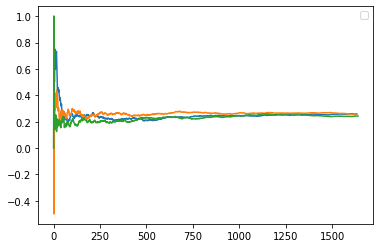

In [ ]:
# if __name__ == '__main__':

#     dir1 = 'data/mushroom_data_final.pickle'

#     ra = RandomAgent()
#     agent_info = {'num_actions': 2}
#     ra.agent_init(agent_info)

#     result = []
#     result1 = []

#     for seed_ in [1, 5, 10]:  # , 2, 3, 32, 123, 76, 987, 2134]:
#         dataset = BanditDataset(pickle_file=dir1, seed=seed_)

#         eval_info = {'dataset': dataset, 'agent': ra}
#         evaluator = OfflineEvaluator(eval_info)

#         reward = evaluator.eval_run()

#         result.append(reward)
#         result1.append(evaluator.total_reward)

#     for elem in result:
#         plt.plot(elem)
#     plt.legend()
#     plt.show()

### Replay Environment

In [ ]:
class ReplayEnvironment(BaseEnvironment):
    dataset: BanditDataset

    def __init__(self):
        super().__init__()
        self.counter = None
        self.last_observation = None

    def env_init(self, env_info=None):
        """
        Set parameters needed to setup the replay SavePilot environment.
        Assume env_info dict contains:
        {
            pickle_file: data directory [str]
        }
        Args:
            env_info (dict):
        """
        if env_info is None:
            env_info = {}

        directory = env_info['pickle_file']
        seed = env_info.get('seed', None)
        self.dataset = BanditDataset(directory, seed)
        self.idxs = range(self.dataset.__len__())
        self.counter = 0

    def _get_observation(self):
        idx = self.idxs[self.counter]

        return self.dataset.__getitem__(idx)

    def env_start(self):
        self.last_observation = self._get_observation()

        state = self.last_observation[0]
        reward = None
        is_terminal = False

        self.reward_state_term = (reward, state, is_terminal)
        self.counter += 1

        # return first state from the environment
        return self.reward_state_term[1]

    def env_step(self, action):
        true_action = self.last_observation[1]
        reward = self.last_observation[2]

        if true_action != action:
            reward = None

        observation = self._get_observation()
        state = observation[0]

        if self.counter == self.dataset.__len__() - 1:
            is_terminal = True
        else:
            is_terminal = False

        self.reward_state_term = (reward, state, is_terminal)

        self.last_observation = observation
        self.counter += 1

        return self.reward_state_term

    def env_cleanup(self):
        pass

    def env_message(self, message):
        pass

## Wrappers

### RL Glue

In [ ]:
class RLGlue:
    """RLGlue class
    args:
        env_name (string): the name of the module where the Environment class can be found
        agent_name (string): the name of the module where the Agent class can be found
    """

    def __init__(self, env_class, agent_class):
        self.environment = env_class()
        self.agent = agent_class()

        self.total_reward = None
        self.average_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None
        self.num_matches = None

    def rl_init(self, agent_init_info={}, env_init_info={}):
        """Initial method called when RLGlue experiment is created"""
        self.environment.env_init(env_init_info)
        self.agent.agent_init(agent_init_info)

        self.total_reward = 0.0
        self.average_reward = [0]
        self.num_steps = 0
        self.num_episodes = 0
        self.num_matches = 0

    def rl_start(self):
        """Starts RLGlue experiment
        Returns:
            tuple: (state, action)
        """

        last_state = self.environment.env_start()
        self.last_action = self.agent.agent_start(last_state)

        observation = (last_state, self.last_action)

        return observation

    def rl_agent_start(self, observation):
        """Starts the agent.
        Args:
            observation: The first observation from the environment
        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_start(observation)

    def rl_agent_step(self, reward, observation):
        """Step taken by the agent
        Args:
            reward (float): the last reward the agent received for taking the
                last action.
            observation : the state observation the agent receives from the
                environment.
        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_step(reward, observation)

    def rl_agent_end(self, reward):
        """Run when the agent terminates
        Args:
            reward (float): the reward the agent received when terminating
        """
        self.agent.agent_end(reward)

    def rl_env_start(self):
        """Starts RL-Glue environment.
        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination
        """
        self.total_reward = 0.0
        self.num_steps = 1

        this_observation = self.environment.env_start()

        return this_observation

    def rl_env_step(self, action):
        """Step taken by the environment based on action from agent
        Args:
            action: Action taken by agent.
        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination.
        """
        ro = self.environment.env_step(action)
        (this_reward, _, terminal) = ro

        self.total_reward += this_reward

        if terminal:
            self.num_episodes += 1
        else:
            self.num_steps += 1

        return ro

    def rl_step(self):
        """Step taken by RLGlue, takes environment step and either step or
            end by agent.
        Returns:
            (float, state, action, Boolean): reward, last state observation,
                last action, boolean indicating termination
        """

        (reward, last_state, term) = self.environment.env_step(self.last_action)

        if reward is not None:
            self.num_matches += 1
            aw_reward = self.average_reward[-1] + (reward - self.average_reward[-1]) / self.num_matches
            self.average_reward.append(aw_reward)
            self.total_reward += reward

        if term:
            self.num_episodes += 1
            self.agent.agent_end(reward)
            roat = (reward, last_state, None, term)
        else:
            self.num_steps += 1
            self.last_action = self.agent.agent_step(reward, last_state)
            roat = (reward, last_state, self.last_action, term)

        return roat

    def rl_cleanup(self):
        """Cleanup done at end of experiment."""
        self.environment.env_cleanup()
        self.agent.agent_cleanup()

    def rl_agent_message(self, message):
        """Message passed to communicate with agent during experiment
        Args:
            message: the message (or question) to send to the agent
        Returns:
            The message back (or answer) from the agent
        """

        return self.agent.agent_message(message)

    def rl_env_message(self, message):
        """Message passed to communicate with environment during experiment
        Args:
            message: the message (or question) to send to the environment
        Returns:
            The message back (or answer) from the environment
        """
        return self.environment.env_message(message)

    def rl_episode(self, max_steps_this_episode):
        """Runs an RLGlue episode
        Args:
            max_steps_this_episode (Int): the maximum steps for the experiment to run in an episode
        Returns:
            Boolean: if the episode should terminate
        """
        is_terminal = False

        self.rl_start()

        while (not is_terminal) and ((max_steps_this_episode == 0) or
                                     (self.num_steps < max_steps_this_episode)):
            rl_step_result = self.rl_step()
            is_terminal = rl_step_result[3]

        return is_terminal

    def rl_return(self):
        """The total reward
        Returns:
            float: the total reward
        """
        return self.total_reward

    def rl_num_steps(self):
        """The total number of steps taken
        Returns:
            Int: the total number of steps taken
        """
        return self.num_steps

    def rl_num_episodes(self):
        """The number of episodes
        Returns
            Int: the total number of episodes
        """
        return self.num_episodes

### Policy

In [ ]:
class Policy:
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.rl_glue = None

    @abstractmethod
    def get_average_performance(self, agent_info=None, env_info=None, exper_info=None):
        raise NotImplementedError

### Bandit wrapper

In [ ]:
class BanditWrapper(Policy):
    def get_average_performance(self, agent_info=None, env_info=None, exper_info=None):

        if exper_info is None:
            exper_info = {}
        if env_info is None:
            env_info = {}
        if agent_info is None:
            agent_info = {}

        num_runs = exper_info.get("num_runs", 100)
        num_steps = exper_info.get("num_steps", 1000)
        return_type = exper_info.get("return_type", None)
        seed = exper_info.get("seed", None)

        np.random.seed(seed)
        seeds = np.random.randint(0, num_runs * 100, num_runs)

        all_averages = []
        subopt_arm_average = []
        best_arm = []
        worst_arm = []
        all_chosen_arm = []
        average_regret = []

        for run in tqdm(range(num_runs)):
            np.random.seed(seeds[run])

            self.rl_glue = RLGlue(self.env, self.agent)
            self.rl_glue.rl_init(agent_info, env_info)
            (first_state, first_action) = self.rl_glue.rl_start()

            worst_position = np.argmin(self.rl_glue.environment.arms)
            best_value = np.max(self.rl_glue.environment.arms)
            worst_value = np.min(self.rl_glue.environment.arms)
            best_arm.append(best_value)
            worst_arm.append(worst_value)

            scores = [0]
            averages = []
            subopt_arm = []
            chosen_arm_log = []

            cum_regret = [0]
            delta = self.rl_glue.environment.subopt_gaps[first_action]
            cum_regret.append(cum_regret[-1] + delta)

            # first action was made in rl_start, that's why run over num_steps-1
            for i in range(num_steps-1):
                reward, _, action, _ = self.rl_glue.rl_step()
                chosen_arm_log.append(action)
                scores.append(scores[-1] + reward)
                averages.append(scores[-1] / (i + 1))
                subopt_arm.append(self.rl_glue.agent.arm_count[worst_position])

                delta = self.rl_glue.environment.subopt_gaps[action]
                cum_regret.append(cum_regret[-1] + delta)

            all_averages.append(averages)
            subopt_arm_average.append(subopt_arm)
            all_chosen_arm.append(chosen_arm_log)

            average_regret.append(cum_regret)

        if return_type is None:
            returns = (np.mean(all_averages, axis=0),
                       np.mean(best_arm))
        elif return_type == 'regret':
            returns = np.mean(average_regret, axis=0)
        elif return_type == 'regret_reward':
            returns = (np.mean(average_regret, axis=0),
                       np.mean(all_averages, axis=0))
        elif return_type == 'arm_choice_analysis':
            returns = (np.mean(all_averages, axis=0),
                       np.mean(best_arm),
                       np.mean(all_chosen_arm, axis=0))
        elif return_type == 'complex':
            returns = (np.mean(all_averages, axis=0),
                       np.mean(subopt_arm_average, axis=0),
                       np.array(best_arm), np.array(worst_arm),
                       np.mean(average_regret, axis=0))

        return returns

### Run experiments

In [ ]:
def run_experiment(environment, agent, environment_parameters, agent_parameters,
                   experiment_parameters, save_data=True, dir=''):
    rl_glue = RLGlue(environment, agent)

    # save sum of reward at the end of each episode
    agent_sum_reward = []

    env_info = environment_parameters
    agent_info = agent_parameters

    # one agent setting
    for run in tqdm(range(1, experiment_parameters["num_runs"] + 1)):
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_episode(0)
        agent_sum_reward.append(rl_glue.average_reward)

    leveled_result = get_leveled_data(agent_sum_reward)
    if save_data:
        save_name = "{}-{}".format(rl_glue.agent.name, rl_glue.agent.batch_size)
        file_dir = "results/{}".format(dir)
        if not os.path.exists(file_dir):
            os.makedirs(file_dir)
        np.save("{}/sum_reward_{}".format(file_dir, save_name), leveled_result)

    return leveled_result

  0%|          | 0/10 [00:00<?, ?it/s]

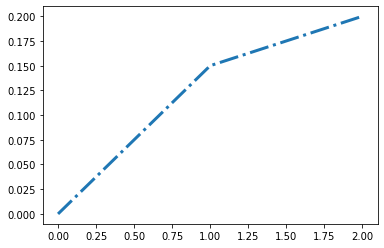

In [ ]:
# if __name__ == '__main__':

#     num_experements = 10
#     batch_size = 100
#     data_dir = 'data/mushroom_data_final.pickle'

#     experiment_parameters = {"num_runs": num_experements}
#     env_info = {'pickle_file': data_dir}
#     agent_info = {'alpha': 2,
#                   'num_actions': 3,
#                   'seed': 1,
#                   'batch_size': 1}

#     agent = LinUCBAgent
#     environment = ReplayEnvironment

#     result = run_experiment(environment, agent, env_info, agent_info, experiment_parameters, save_data=False)

#     smoothed_leveled_result = smooth(result, 100)
#     mean_smoothed_leveled_result = np.mean(smoothed_leveled_result, axis=0)

#     plt.plot(mean_smoothed_leveled_result, lw=3, ls='-.', label='online policy')
#     plt.show()

## Experiments

### UCB

#### UCB dynamic by timesteps

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

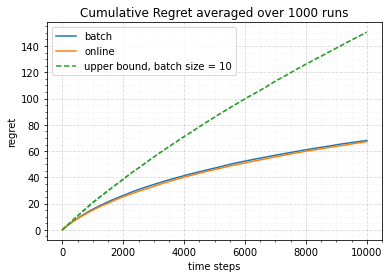

In [ ]:
env = Environment
agent = UCBAgent

alpha = 1

num_runs = 1000
num_steps = 10000
seed = None
if_save = False
exper_info = {"num_runs": num_runs,
              "num_steps": num_steps,
              "seed": seed,
              "return_type": "regret"}

k = 2
arms_values = [0.7, 0.65]
reward_type = 'Bernoulli'
env_info = {"num_actions": k,
            "reward_type": reward_type,
            "arms_values": arms_values}

# batch-online experiment
batch_res = []
online_res = []
batch = 10
agent_info_batch = {"num_actions": k, "batch_size": batch, "alpha": alpha}
agent_info_online = {"num_actions": k, "batch_size": 1, "alpha": alpha}

exp1 = BanditWrapper(env, agent)
batch_res.append(exp1.get_average_performance(agent_info_batch, env_info, exper_info))
online_res.append(exp1.get_average_performance(agent_info_online, env_info, exper_info))

av_online_res = np.mean(online_res, axis=0)
av_batch_res = np.mean(batch_res, axis=0)

plt.plot(av_batch_res, label='batch')
plt.plot(av_online_res, label='online')

M = int(num_steps / batch)
update_points = np.ceil(np.arange(num_steps) / batch).astype(int)
plt.plot(av_online_res[update_points] * batch, ls='--',
         label='upper bound, batch size = 10')
plt.title('Cumulative Regret averaged over ' + str(num_runs) + ' runs')
plt.xlabel('time steps')
plt.ylabel('regret')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.legend()
if if_save:
    plt.savefig('results/UCB transform example.png', bbox_inches='tight')
plt.show()

if if_save:
    name = 'batch_result, runs=' + str(num_runs) + ', steps=' + str(num_steps)
    with open('results/' + '/' + name + '.pickle', 'wb') as handle:
        pickle.dump(batch_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### UCB dynamic by batches

In [ ]:
model_dir = 'results/UCB/dynamic_by_batches'
if not os.path.exists(model_dir):
    print(f'Creating a new model directory: {model_dir}')
    os.makedirs(model_dir)

num_runs = 10 # 500
num_steps = 10001
seed = None
exper_info = {"num_runs": num_runs,
              "num_steps": num_steps,
              "seed": seed,
              "return_type": "regret"}

environments = [[0.7, 0.5], [0.7, 0.4], [0.7, 0.1],
                [0.35, 0.18, 0.47, 0.61],
                [0.4, 0.75, 0.57, 0.49],
                [0.70, 0.50, 0.30, 0.10]]

for arms_values in environments:
    k = len(arms_values)
    reward_type = 'Bernoulli'
    env_info = {"num_actions": k,
                "reward_type": reward_type,
                "arms_values": arms_values}
    env = Environment
    agent = UCBAgent
    alpha = 1

    # run online agent
    agent_info_online = {"num_actions": k, "batch_size": 1, "alpha": alpha}
    experiment = BanditWrapper(env, agent)
    online_regret = experiment.get_average_performance(agent_info_online, env_info, exper_info)

    # run batch agent
    batches = np.logspace(1.0, 3.0, num=20).astype(int)
    actual_regret = []
    upper_bound = []

    for batch in batches:
        agent_info_batch = {"num_actions": k, "batch_size": batch, "alpha": alpha}
        experiment = BanditWrapper(env, agent)
        batch_regret = experiment.get_average_performance(agent_info_batch, env_info, exper_info)
        actual_regret.append(batch_regret[-1])
        M = int(num_steps / batch)
        upper_bound.append(online_regret[M] * batch)

    # save data
    name = 'dyn_by_batch_' + str(arms_values)
    name1 = name + ' batch_regret'
    with open(model_dir + '/' + name1 + '.pickle', 'wb') as handle:
        pickle.dump(actual_regret, handle, protocol=pickle.HIGHEST_PROTOCOL)

    name2 = name + ' online_regret'
    with open(model_dir + '/' + name2 + '.pickle', 'wb') as handle:
        pickle.dump(online_regret, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("End!")

### TS

#### TS dynamic by timesteps

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

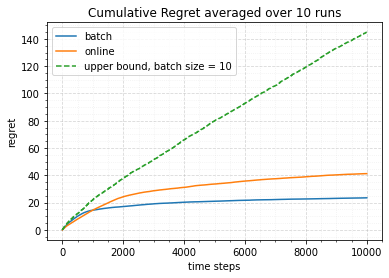

In [ ]:
env = Environment
agent = TSAgent

num_runs = 10 # 1000
num_steps = 10000
seed = None
if_save = False
exper_info = {"num_runs": num_runs,
              "num_steps": num_steps,
              "seed": seed,
              "return_type": "regret"}

k = 2
arms_values = [0.7, 0.65]
reward_type = 'Bernoulli'
env_info = {"num_actions": k,
            "reward_type": reward_type,
            "arms_values": arms_values}

# batch-online experiment
batch_res = []
online_res = []
batch = 10
agent_info_batch = {"num_actions": k, "batch_size": batch}
agent_info_online = {"num_actions": k, "batch_size": 1}

exp1 = BanditWrapper(env, agent)
batch_res.append(exp1.get_average_performance(agent_info_batch, env_info, exper_info))
online_res.append(exp1.get_average_performance(agent_info_online, env_info, exper_info))

av_online_res = np.mean(online_res, axis=0)
av_batch_res = np.mean(batch_res, axis=0)

plt.plot(av_batch_res, label='batch')
plt.plot(av_online_res, label='online')

M = int(num_steps / batch)
update_points = np.ceil(np.arange(num_steps) / batch).astype(int)
plt.plot(av_online_res[update_points] * batch, ls='--',
         label='upper bound, batch size = 10')
plt.title('Cumulative Regret averaged over ' + str(num_runs) + ' runs')
plt.xlabel('time steps')
plt.ylabel('regret')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.legend()
if if_save:
    plt.savefig('results/TS  example.png', bbox_inches='tight')
plt.show()

if if_save:
    name = 'batch_result, runs=' + str(num_runs) + ', steps=' + str(num_steps)
    with open('results/' + '/' + name + '.pickle', 'wb') as handle:
        pickle.dump(batch_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### TS dynamic by batches

In [ ]:
model_dir = 'results/TS/dynamic_by_batches'
if not os.path.exists(model_dir):
    print(f'Creating a new model directory: {model_dir}')
    os.makedirs(model_dir)

num_runs = 10 # 500
num_steps = 10001
seed = None
exper_info = {"num_runs": num_runs,
              "num_steps": num_steps,
              "seed": seed,
              "return_type": "regret"}

environments = [[0.7, 0.5], [0.7, 0.4], [0.7, 0.1],
                [0.35, 0.18, 0.47, 0.61],
                [0.4, 0.75, 0.57, 0.49],
                [0.70, 0.50, 0.30, 0.10]]

for arms_values in environments:
    k = len(arms_values)
    reward_type = 'Bernoulli'
    env_info = {"num_actions": k,
                "reward_type": reward_type,
                "arms_values": arms_values}
    env = Environment
    agent = TSAgent

    # run online agent
    agent_info_online = {"num_actions": k, "batch_size": 1}
    experiment = BanditWrapper(env, agent)
    online_regret = experiment.get_average_performance(agent_info_online, env_info, exper_info)

    # run batch agent
    batches = np.logspace(1.0, 3.0, num=20).astype(int)
    actual_regret = []
    upper_bound = []

    for batch in batches:
        agent_info_batch = {"num_actions": k, "batch_size": batch}
        experiment = BanditWrapper(env, agent)
        batch_regret = experiment.get_average_performance(agent_info_batch, env_info, exper_info)
        actual_regret.append(batch_regret[-1])
        M = int(num_steps / batch)
        upper_bound.append(online_regret[M] * batch)

    # save data
    name = 'dyn_by_batch_' + str(k) + str(arms_values)
    name1 = name + ' batch_regret'
    with open(model_dir + '/' + name1 + '.pickle', 'wb') as handle:
        pickle.dump(actual_regret, handle, protocol=pickle.HIGHEST_PROTOCOL)

    name2 = name + ' online_regret'
    with open(model_dir + '/' + name2 + '.pickle', 'wb') as handle:
        pickle.dump(online_regret, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("End!")

### LinUCB

#### LinUCB by timesteps

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

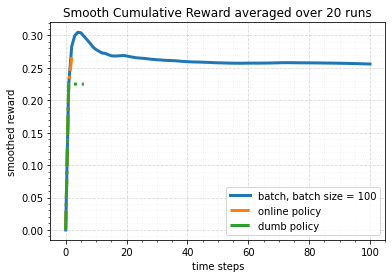

In [ ]:
num_experiments = 20
batch_size = 100
data_dir = 'data/mushroom_data_final.pickle'
env_info = {'pickle_file': data_dir}
output_dir = 'LinUCB/dynamic_by_timesteps'

agent_info = {'alpha': 2,
              'num_actions': 3,
              'seed': 1,
              'batch_size': 1}
agent_info_batch = {'alpha': 2,
                    'num_actions': 3,
                    'seed': 1,
                    'batch_size': batch_size}
experiment_parameters = {"num_runs": num_experiments}

agent = LinUCBAgent
environment = ReplayEnvironment

online_result = run_experiment(environment, agent, env_info, agent_info,
                               experiment_parameters, True, output_dir)
batch_result = run_experiment(environment, agent, env_info, agent_info_batch,
                              experiment_parameters, True, output_dir)

smoothed_leveled_result = smooth(online_result, 100)
smoothed_leveled_result1 = smooth(batch_result, 100)

mean_smoothed_leveled_result = np.mean(smoothed_leveled_result, axis=0)
mean_smoothed_leveled_result1 = np.mean(smoothed_leveled_result1, axis=0)

num_steps = np.minimum(len(mean_smoothed_leveled_result), len(mean_smoothed_leveled_result1))
update_points = np.ceil(np.arange(num_steps) / batch_size).astype(int)

pic_filename = "results/{}/UCB_transform_timesteps.png".format(output_dir)
plt.plot(mean_smoothed_leveled_result1, lw=3, label='batch, batch size = ' + str(batch_size))
plt.plot(mean_smoothed_leveled_result, lw=3, ls='-.', label='online policy')
plt.plot(mean_smoothed_leveled_result[update_points], lw=3, ls='-.', label='dumb policy')
plt.legend()
plt.xlabel('time steps')
plt.title("Smooth Cumulative Reward averaged over {} runs".format(num_experiments))
plt.ylabel('smoothed reward')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.savefig(pic_filename, bbox_inches='tight')
plt.show()

#### LinUCB by batches

In [ ]:
num_experiments = 20
data_dir = 'data/mushroom_data_final.pickle'
env_info = {'pickle_file': data_dir}
output_dir = 'LinUCB/dynamic_by_batches'

agent_info = {'alpha': 2,
              'num_actions': 3,
              'seed': 1,
              'batch_size': 1}
experiment_parameters = {"num_runs": num_experiments}

agent = LinUCBAgent
environment = ReplayEnvironment

# run online agent
online_result = run_experiment(environment, agent, env_info, agent_info,
                               experiment_parameters, True, output_dir)
# smooth and average the result
smoothed_leveled_result = smooth(online_result, 100)
mean_smoothed_leveled_result = np.mean(smoothed_leveled_result, axis=0)
mean_smoothed_leveled_result = mean_smoothed_leveled_result[~np.isnan(mean_smoothed_leveled_result)]

# run batch agent
batch_sizes = np.logspace(1.0, 2.7, num=20).astype(int)
actual_regret = []
upper_bound = []
for batch in batch_sizes:
    agent_info_batch = {'alpha': 2,
                        'num_actions': 3,
                        'seed': 1,
                        'batch_size': batch}
    batch_result = run_experiment(environment, agent, env_info, agent_info_batch,
                                  experiment_parameters, True, output_dir)
    # smooth and average the result
    smoothed_leveled_result1 = smooth(batch_result, 100)
    mean_smoothed_leveled_result1 = np.mean(smoothed_leveled_result1, axis=0)
    mean_smoothed_leveled_result1 = mean_smoothed_leveled_result1[~np.isnan(mean_smoothed_leveled_result1)]

    actual_regret.append(mean_smoothed_leveled_result1[-1])

    # fetch dumb result
    M = int(len(mean_smoothed_leveled_result1) / batch)
    upper_bound.append(mean_smoothed_leveled_result[M])

pic_filename = "results/{}/UCB_transform_batchsize.png".format(output_dir)
plt.plot(batch_sizes, actual_regret, label='actual regret')
plt.plot(batch_sizes, [mean_smoothed_leveled_result[-1]]*len(batch_sizes), label='online policy')
plt.plot(batch_sizes, upper_bound, label='dumb policy')
plt.legend()
plt.title("Reward as a f-n of batch size (each point is averaged over {} runs)".format(num_experiments))
plt.xlabel('batch size (log scale)')
plt.ylabel('reward')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.savefig(pic_filename, bbox_inches='tight')
plt.show()

### LinTS

#### LinTS by timesteps

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

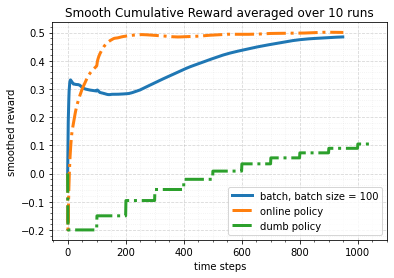

In [ ]:
num_experiments = 10
batch_size = 100
data_dir = 'data/mushroom_data_final.pickle'
env_info = {'pickle_file': data_dir}
output_dir = 'LinTS/dynamic_by_timesteps'

agent_info = {'alpha': 1,
              'num_actions': 3,
              'seed': 1,
              'batch_size': 1,
              'replay_buffer_size': 100000}
agent_info_batch = {'alpha': 1,
                    'num_actions': 3,
                    'seed': 1,
                    'batch_size': batch_size,
                    'replay_buffer_size': 100000}
experiment_parameters = {"num_runs": num_experiments}

agent = LinTSAgent
environment = ReplayEnvironment

online_result = run_experiment(environment, agent, env_info, agent_info,
                               experiment_parameters, True, output_dir)
batch_result = run_experiment(environment, agent, env_info, agent_info_batch,
                              experiment_parameters, True, output_dir)

smoothed_leveled_result = smooth(online_result, 100)
smoothed_leveled_result1 = smooth(batch_result, 100)

mean_smoothed_leveled_result = np.mean(smoothed_leveled_result, axis=0)
mean_smoothed_leveled_result1 = np.mean(smoothed_leveled_result1, axis=0)

num_steps = np.minimum(len(mean_smoothed_leveled_result), len(mean_smoothed_leveled_result1))
update_points = np.ceil(np.arange(num_steps) / batch_size).astype(int)

pic_filename = "results/{}/TS_transform_timesteps.png".format(output_dir)
plt.plot(mean_smoothed_leveled_result1, lw=3, label='batch, batch size = ' + str(batch_size))
plt.plot(mean_smoothed_leveled_result, lw=3, ls='-.', label='online policy')
plt.plot(mean_smoothed_leveled_result[update_points], lw=3, ls='-.', label='dumb policy')
plt.legend()
plt.xlabel('time steps')
plt.title("Smooth Cumulative Reward averaged over {} runs".format(num_experiments))
plt.ylabel('smoothed reward')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.savefig(pic_filename, bbox_inches='tight')
plt.show()

#### LinTS by batches

In [ ]:
num_experiments = 20
data_dir = 'data/mushroom_data_final.pickle'
env_info = {'pickle_file': data_dir}
output_dir = 'LinTS/dynamic_by_batches'

agent_info = {'alpha': 1,
              'num_actions': 3,
              'seed': 1,
              'batch_size': 1,
              'replay_buffer_size': 100000}
experiment_parameters = {"num_runs": num_experiments}

agent = LinTSAgent
environment = ReplayEnvironment

# run online agent
online_result = run_experiment(environment, agent, env_info, agent_info,
                               experiment_parameters, True, output_dir)
# smooth and average the result
smoothed_leveled_result = smooth(online_result, 100)
mean_smoothed_leveled_result = np.mean(smoothed_leveled_result, axis=0)
mean_smoothed_leveled_result = mean_smoothed_leveled_result[~np.isnan(mean_smoothed_leveled_result)]

# run batch agent
batch_sizes = np.logspace(1.0, 2.7, num=20).astype(int)
actual_regret = []
upper_bound = []
for batch in batch_sizes:
    agent_info_batch = {'alpha': 1,
                        'num_actions': 3,
                        'seed': 1,
                        'batch_size': batch,
                        'replay_buffer_size': 100000}
    batch_result = run_experiment(environment, agent, env_info, agent_info_batch,
                                  experiment_parameters, True, output_dir)
    # smooth and average the result
    smoothed_leveled_result1 = smooth(batch_result, 100)
    mean_smoothed_leveled_result1 = np.mean(smoothed_leveled_result1, axis=0)
    mean_smoothed_leveled_result1 = mean_smoothed_leveled_result1[~np.isnan(mean_smoothed_leveled_result1)]

    actual_regret.append(mean_smoothed_leveled_result1[-1])

    # fetch dumb result
    M = int(len(mean_smoothed_leveled_result1) / batch)
    upper_bound.append(mean_smoothed_leveled_result[M])

pic_filename = "results/{}/TS_transform_batchsize.png".format(output_dir)
plt.plot(batch_sizes, actual_regret, label='actual regret')
plt.plot(batch_sizes, [mean_smoothed_leveled_result[-1]]*len(batch_sizes), label='online policy')
plt.plot(batch_sizes, upper_bound, label='dumb policy')
plt.legend()
plt.title("Reward as a f-n of batch size (each point is averaged over {} runs)".format(num_experiments))
plt.xlabel('batch size (log scale)')
plt.ylabel('reward')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.savefig(pic_filename, bbox_inches='tight')
plt.show()

### CMAB demo on Mushroom dataset

In [ ]:
data_dir = 'data/mushroom_data_final.pickle'
env_info = {'pickle_file': data_dir,
            'seed': 1}
# init env
environment = ReplayEnvironment

# init random agent
random_agent_info = {'num_actions': 2}
ra = RandomAgent()
ra.agent_init(random_agent_info)

# learn LinUCB agent
agent_info = {'alpha': 2,
              'num_actions': 2,
              'seed': 1,
              'batch_size': 1}

agent = LinUCBAgent
rl_glue = RLGlue(environment, agent)

for i in range(4):    
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_episode(0)
UCB_agent = rl_glue.agent

# learn LinTS agent
agent_info = {'num_actions': 2,
              'replay_buffer_size': 200,
              'seed': 1,
              'batch_size': 1}
agent = LinTSAgent
rl_glue = RLGlue(environment, agent)

for i in range(4):    
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_episode(0)

TS_agent = rl_glue.agent
result = []
result1 = []
result2 = []

exper_seeds = [2, 5, 10, 12, 54, 32, 15, 76, 45, 56]
for seed_ in exper_seeds:
    dataset = BanditDataset(pickle_file=data_dir, seed=seed_)

    eval_info = {'dataset': dataset, 'agent': UCB_agent}
    eval_info1 = {'dataset': dataset, 'agent': TS_agent}
    eval_info2 = {'dataset': dataset, 'agent': ra}

    evaluator = OfflineEvaluator(eval_info)
    evaluator1 = OfflineEvaluator(eval_info1)
    evaluator2 = OfflineEvaluator(eval_info2)

    reward = evaluator.eval_run()
    reward1 = evaluator1.eval_run()
    reward2 = evaluator2.eval_run()

    result.append(reward)
    result1.append(reward1)
    result2.append(reward2)

labels = ['UCB agent', 'TS agent', 'Random agent']
for i, res in enumerate([result, result1, result2]):
    for elem in res:
        plt.plot(elem, linewidth=0.1)
    avg = [float(sum(col))/len(col) for col in zip(*res)]
    plt.plot(avg, label=labels[i])

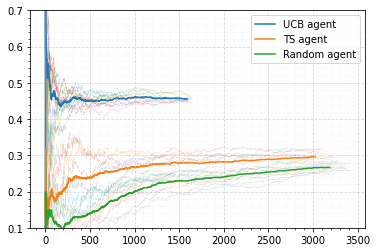

In [ ]:
labels = ['UCB agent', 'TS agent', 'Random agent']
for i, res in enumerate([result, result1, result2]):
    for elem in res:
        plt.plot(elem, linewidth=0.1)
    avg = [float(sum(col))/len(col) for col in zip(*res)]
    plt.plot(avg, label=labels[i])
plt.legend()
plt.ylim([0.1, 0.7])
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.show()

### CMAB demo on Simulated dataset

In [ ]:
# generate 100 000 samples with 4 features and 3 actions
dataset = generate_samples(100000, 4, 3, True)
dataset.head()

,X_1,X_2,X_3,X_4,a,y,probs
0,1,3,0,0,0.0,0.0,0.266661
1,3,1,3,1,1.0,0.0,0.236514
2,3,0,0,1,1.0,0.0,0.236514
3,0,3,1,0,1.0,0.0,0.236514
4,2,1,2,0,0.0,0.0,0.266661


#### LinTS dynamic by steps

In [ ]:
num_experiments = 10
batch_size1 = 30
batch_size2 = 100
env_info = {'pickle_file': dataset}

agent1_info = {'alpha': 1,
              'num_actions': 3,
              'seed': 1,
              'batch_size': batch_size1,
              'replay_buffer_size': 100000}
agent2_info = {'alpha': 1,
                    'num_actions': 3,
                    'seed': 1,
                    'batch_size': batch_size2,
                    'replay_buffer_size': 100000}
experiment_parameters = {"num_runs": num_experiments}

In [ ]:
agent = LinTSAgent
environment = ReplayEnvironment

result1 = run_experiment(environment, agent, env_info, agent1_info, experiment_parameters, False)
result2 = run_experiment(environment, agent, env_info, agent2_info, experiment_parameters, False)

smoothed_leveled_result1 = smooth(result1, 100)
smoothed_leveled_result2 = smooth(result2, 100)

mean_smoothed_leveled_result1 = np.mean(smoothed_leveled_result1, axis=0)
mean_smoothed_leveled_result2 = np.mean(smoothed_leveled_result2, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

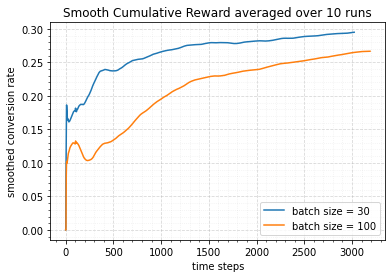

In [ ]:
plt.plot(mean_smoothed_leveled_result1, label='batch size = ' + str(batch_size1))
plt.plot(mean_smoothed_leveled_result2, label='batch size = ' + str(batch_size2))
plt.legend()
plt.xlabel('time steps')
plt.title("Smooth Cumulative Reward averaged over {} runs".format(num_experiments))
plt.ylabel('smoothed conversion rate')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.show()

#### LinTS dynamic by batches

In [ ]:
num_experiments = 20
env_info = {'pickle_file': dataset}
experiment_parameters = {"num_runs": num_experiments}

agent = LinTSAgent
environment = ReplayEnvironment

# run batch agent
batch_sizes = np.logspace(1.0, 2.7, num=20).astype(int)
actual_regret = []
for batch in batch_sizes:
    agent_info_batch = {'alpha': 1,
                        'num_actions': 3,
                        'seed': 1,
                        'batch_size': batch,
                        'replay_buffer_size': 100000}
    batch_result = run_experiment(environment, agent, env_info, agent_info_batch,
                                  experiment_parameters, False)
    # smooth and average the result
    smoothed_leveled_result1 = smooth(batch_result, 100)
    mean_smoothed_leveled_result1 = np.mean(smoothed_leveled_result1, axis=0)
    mean_smoothed_leveled_result1 = mean_smoothed_leveled_result1[~np.isnan(mean_smoothed_leveled_result1)]

    actual_regret.append(mean_smoothed_leveled_result1[-1])

In [ ]:
plt.plot(batch_sizes, actual_regret, label='actual regret')
plt.legend()
plt.title("Reward as a f-n of batch size (each point is averaged over {} runs)".format(num_experiments))
plt.xlabel('batch size (log scale)')
plt.ylabel('reward')
plt.grid(b=True, which='major', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle=':', alpha=0.2)
plt.show()